**Educational Attainment and Success**


---


Chieh-Huang Chen \
Melvin Cherian \
Michael LI \


---

Course: CSC 59970 - Introduction to Data Science \
Instructor: Grant M. Long
Project



**Goals for this Project**

1.  Apply Python to load, clean, and process data sets.
2.  Identify key patterns in a data set using computational analysis and statistical methods.
3.  Apply principles of statistical modeling and machine learning to data.
4.  Effectively explain, visualize, and communicate empirical findings.


---

**Our Questions**


*   What human development indicators strongly correlate with adult education level in countries?
*   What are significant factors from each major category from the human development dataset that determines adult education level in countries?
*   Which countries have a strong potential in increasing their education level within the next five years?

---

*Thoughts from Chieh (Remove this before submitting the final project)*

1. Use the dataset and find potential indicators that have high coorelations with Education Index (https://en.wikipedia.org/wiki/Education_Index), which is used to judge each countries' education level based on the number of years a child is expected to attend school or university and the average number of years of education received by people ages 25 and older.

2.  Find the potential indicators for each country and use those potential indicators to predict education index through linear regression.

3. Assumptions of Linear Regression \
a.  Data is linear in form. \
b.  Sample is random. \
c.  Error terms have constant variance (homoscedasticity). \
d.  Error terms have a mean of zero based on the observed data. \
e.  Predictors are independent (no multicollinearity). \
f.   Errors are normally distributed. \

4. How to satisfy these assumptions from #3? \
a. Check if the correlation of determination is greater than 0.7  \
b. The data that we collected represents the consenus of the entire country. \
c. There's a constant variance because it's yearly. \
d. Get the standard error of the array and see if it is similar. \
e. Use an algorithm to remove coorelations between predictors. \
f. Yes it is. \

---

*Thoughts from Melvin (Remove this before submitting the final project)*


---

*Thoughts from Michael (Remove this before submitting the final project)*

1. Use the dataset to find the effect of several health indicators on Education index, Pisa scores, and years of schooling.





*Libraries*


*   Numpy
*   Pandas
*   Matplotlib



In [2]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

*Loading Data into Memory*

---

We loaded two datasets into memory: Adult Education Level (AEL) dataset and Human Development Indicators (HDI) dataset.

We specifically removed column 9999 from our dataset because it only shows the latest value from the data drawn within 1990 to 2017. In this analysis, we analyzed these indicators over time to predict the future of education level in each country.

In [3]:
# Loading Datasets on to DataFrames
indicators_url = 'https://github.com/chc5/education-indicator-analysis/raw/master/2018_all_indicators.csv'
education_url = 'https://github.com/chc5/education-indicator-analysis/raw/master/adult_education_level.csv'

inds_df = pd.read_csv(indicators_url)
ed_df = pd.read_csv(education_url)

inds_df = inds_df.drop(columns=['9999'])

Many of our HDIs only have zero or one recordings in the dataset in years between 1990 to 2017. Due to the lack of data over time, we decided to remove these indicators that has at most 2 data points in each row.

When we removed these indicators, it cleans up at least 28% of the HDI dataset.

In [4]:
# Many indicators from 1990 to 2017 that only have at most one or two recordings for a specific indicators.
# These recordings may or may not indicate growth over the years which will not contribute to our analysis.
# These indicators will be dropped.
# When threshold = 1, it removed 25636 - 20588 = 5048 / 25636 = 20% of the indicators
threshold = 0
drop_stack = set()
length_before = len(inds_df)
print("Number of rows in the indicators data frame before the cleanup:", length_before)
for index, row in inds_df.iterrows():
    if row['1990':].count() <= threshold:
        drop_stack.add(index)

inds_df = inds_df.drop(drop_stack)
length_after = len(inds_df)
print("Number of rows in the indicators data frame after the cleanup:", length_after)
print("% of rows deleted: {0:.2f}%".format((length_before - length_after) * 100 / length_after))


Number of rows in the indicators data frame before the cleanup: 25636
Number of rows in the indicators data frame after the cleanup: 22918
% of rows deleted: 11.86%


# Do not run this code segment
I believe it that it interferes with the coorelations drawn \
Also, these are predicted values, not actual values.

In [0]:
# Do not run this code segment, I believe it that it interferes with the coorelations drawn
# Also, these are predicted values, not actual values.

# Get the missing values at each year and return the array of years (aka. column)
def get_missing_yearly_values(row):
    row_df = row.to_frame().reset_index()
    row_df = row_df.drop(range(5))
    row_df.columns = ['x', 'y']
    missing_X = row_df[row_df['y'].isnull()].x
    return missing_X

# Predicting the missing values using Linear Regression Models
# and then filling out the missing values based on the model
year_columns = inds_df.columns.values[5:]
for index, row in inds_df.iterrows():
    missing_years = get_missing_yearly_values(row).values
    # If there are nothing to fill out then we don't need to model it out.
    if missing_years.size <= 0:
        continue
    row = row.drop(missing_years)
    row = row.drop(['dimension', 'indicator_id', 'indicator_name', 'iso3', 'country_name'])
    value = row.values.reshape(-1, 1)
    year = year_columns
    # The difference set of total years and missing years are the years where there are recorded values.
    year = np.setdiff1d(year, missing_years).astype(int).reshape(-1, 1)
    missing_years = missing_years.astype(int)
    missing_years = missing_years.reshape(missing_years.shape[0],-1)
    
    reg = LinearRegression()
    reg.fit(year, value)
    missing_values = reg.predict(missing_years)
    # Filling out the missing data
    for i in range(len(missing_years)):
        inds_df.at[index, str(missing_years[i][0])] = missing_values[i][0]
        

*Plotting Correlations for each country*

We have a method to retrieve each indicators for a country we specify for future uses.

In [0]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
  
def plot_corr_country(df, country):
  # drop ids etc., get only rows with country, transpose
  df_corr = inds_df.drop(df.columns[[0, 1, 3]], axis=1)[df.country_name == country].T
  # fix columns
  df_corr.columns = df_corr.iloc[0]
  # drop first two rops
  df_corr = df_corr[2:]
  # df_corr = inds_df.drop(inds_df.columns[[0, 1, 3]], axis=1).drop(inds_df.columns[range(5,32)], axis=1)[inds_df.country_name == "Albania"]
  df_corr = df_corr.apply(pd.to_numeric)
#   plot_corr(df_corr, size=20)
  return df_corr

### How do we determine the strongest indicators to Education Index for each country?

**Education Index:** A standard created by United Nations that determines educational attainment for each country. \
**Formula:** MYSI + EYSI / 2 \
Mean Years of Schooling Index(MYSI): MYS / 15 \
Mean Years of Schooling(MYS): Average number of years of education received by people ages 25 and older. \
Expected Years of Schooling Index(EYSI): EYS / 18 \
Expected Years of Schooling(EYS): The number of years a child is expected to attend school, or university, including the years spent on repetition. \

*Source: https://en.wikipedia.org/wiki/Education_Index* 



---


We get the strongest correlations for each country by getting the correlation coefficient between the Education Index to every other indicator in the row for that country. By squaring the correlation coefficient, we get the correlation of determination (R^2) which tells us the percentage of the variance in our dependent variable that can be explained by our independent variable. In this case, we sorted the indicators based on the correlation of determination and remove all the indicators where its correlation of determination to the Education Index is less than 0.7.

We then dropped the indicators that are directly dependent to the Education Index based on the formula such as 'Education index', 'Expected years of schooling (years)' and 'Mean years of schooling (years)'.

In [0]:
# Get the strongest indicators towards the Education Index by getting the strongest correlation of determination (R^2)
# between every other indicators to the Education Index. 
def get_strongest_correlations(df_corr, indicator, num_indicators = 100, threshold=0.7):
    correlations = []
    for row in df_corr.corr():
        corr_determ = df_corr.corr()[row][indicator] ** 2
        if corr_determ >= threshold:
          correlations.append([row, corr_determ])
    
    correlations.sort(key = lambda corr: corr[1], reverse=True)
    return correlations[:num_indicators]

In [0]:
# Remove multicollinearity betweeen the potential indicators by checking the coorelations between the two indicators.
# If there is a coorelation between the potential indicators, then remove the indicator that is least correlated with
# the dependent variable out of the two.
def remove_multicollinearity(df, features, target, threshold=0.8):
  correlations = df.corr()
  # Remove the target in the features list if it is in there.
  temp = [f for f in features if f != target]
  i = 0
  while i < len(temp):
    redo = False
    for f in temp:
      if correlations[f][temp[i]] > threshold \
        and correlations[temp[i]][target] < correlations[f][target]:
        temp[i], temp[-1] = temp[-1], temp[i]
        temp.pop()
        redo = True
        break
    if not redo:
      i += 1
  return temp


In [0]:
# Get potential indicators from countries
def get_potential_indicators(df, country, target, ignored_features=[], multicollinearity=False):
  country_df = plot_corr_country(df, country)
  if target not in country_df:
    print("{} does not have an {}".format(country, target))
    return []
  potential_indicators = get_strongest_correlations(country_df, target)
  features = [p[0] for p in potential_indicators if p[0] not in ignored_features] 
  if not multicollinearity:
    features = remove_multicollinearity(country_df, features, target)
  return features



In [11]:
# Dropping 'Education index', 'Expected years of schooling (years)', 'Mean years of schooling (years)' and others because they are part of the formula
dep_ed_ind = ['Education index', 
                 'Expected years of schooling (years)', 
                 'Mean years of schooling (years)', 
                 # I don't know if the indicators below is dependent to the education index. They might tell an interesting story.
                 'Expected years of schooling, female (years)', 
                 'Mean years of schooling, female (years)',
                 'Expected years of schooling, male (years)',
                 'Expected years of schooling, male (years)',
                 'Mean years of schooling, male (years)',
                 'Human Development Index (HDI)'
                ]   

target = 'Education index'
top_indicators = {}
country_names = inds_df.country_name.unique()
for c in country_names:
  features = get_potential_indicators(inds_df, c, target, dep_ed_ind, True)
  for f in features:
    if f in top_indicators:
      top_indicators[f] += 1
    else:
      top_indicators[f] = 1

sorted_top_indicators = sorted(top_indicators.items(), key=lambda kv: kv[1], reverse=True)
for ind in sorted_top_indicators:
  print(ind)

Korea (Democratic People's Rep. of) does not have an Education index
Somalia does not have an Education index
Marshall Islands does not have an Education index
Monaco does not have an Education index
Nauru does not have an Education index
San Marino does not have an Education index
Tuvalu does not have an Education index
('Median age (years)', 162)
('Life expectancy at birth (years)', 161)
('Life expectancy index', 161)
('Mortality rate, infant (per 1,000 live births)', 157)
('Life expectancy at birth, female (years)', 155)
('Mortality rate, under-five (per 1,000 live births)', 155)
('Human Development Index (HDI), male', 155)
('Human Development Index (HDI), female', 154)
('Life expectancy at birth, male (years)', 153)
('Urban population (%)', 146)
('Gross domestic product (GDP), total (2011 PPP $ billions)', 142)
('Adolescent birth rate (births per 1,000 women ages 15-19)', 141)
('Internet users, total (% of population)', 140)
('Young age (0-14) dependency ratio (per 100 people ages 

-----Health
In theory a better score in various health indicators should lead to a higher overall education score. If a person is healthier, then they will be capable of spending more time in school which will allow them to gain more knowledge.
How does life expectancy affect education?
Both life expectancy and Mean school years with respect to Life expectancy create a similar graph.

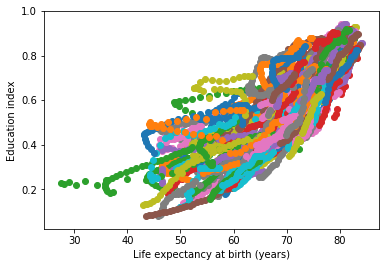

In [25]:
def plot_health(df, health_indep, target):
    health_df = df.drop(df.columns[[0, 1, 3]], axis=1)
    #obtain rows that have the indicator matching health_indep and target respectively
    health_indicator_data = health_df[health_df.indicator_name == health_indep]
    education_index = health_df[health_df.indicator_name == target]
    for i in range(len(health_indicator_data)):
        health_i = []
        education_i = []
        #finds the pairs by going across each country's row
        for j in range(1990, 2018):
            c_val = health_indicator_data["country_name"].iloc[i]
            #checks if country is in both sections and then add both to respective list
            if c_val in list(education_index["country_name"]):
                health_i.append(health_indicator_data[str(j)].iloc[i])
                education_i.append(education_index[education_index.country_name == c_val][str(j)].iloc[0])
        #plots each time a country is done
        plt.scatter(health_i, education_i)
    plt.xlabel(health_indep)
    plt.ylabel(target)
    #plt.scatter(health_i, education_i)
    #Best fit line error: SVD did not converge in Linear Least Squares
    #running the fourth code should fix 
    #fit = np.polyfit(health_i, education_i, 1)
    #fit_fn = np.poly1d(fit)
    #plt.plot(health_i, fit_fn(health_i), color="red")
plot_health(inds_df, "Life expectancy at birth (years)", "Education index")

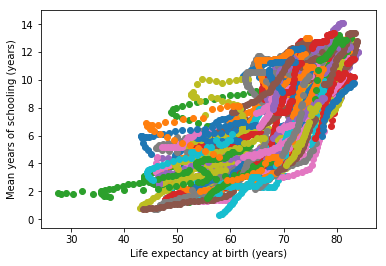

In [27]:
plot_health(inds_df, "Life expectancy at birth (years)", "Mean years of schooling (years)")

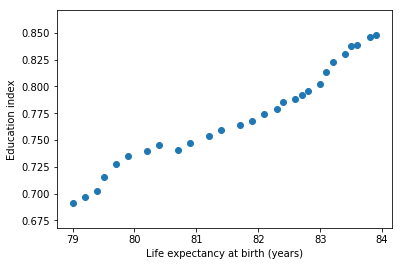

In [34]:
def plot_health_by_country(df, health_indep, target, country):
    health_df = df.drop(df.columns[[0, 1, 3]], axis=1)
    #obtain rows that have the indicator matching health_indep and target respectively
    health_indicator_data = health_df[health_df.indicator_name == health_indep]
    education_target = health_df[health_df.indicator_name == target]
    #if country not in both return
    if country not in list(education_target["country_name"]) or country not in list(health_indicator_data["country_name"]):
        print("Country value missing from a variable")
        return
    #Further limits rows to the rows with country_name equal to country
    country_health = health_indicator_data[health_indicator_data.country_name == country]
    country_education_target = education_target[education_target.country_name == country]
    health_i = []
    education_i = []
    #adds values to respective list
    for j in range(1990, 2018):
        health_i.append(country_health[str(j)].iloc[0])
        education_i.append(country_education_target[country_education_target.country_name == country][str(j)].iloc[0])
    #plots the data points for the country
    plt.scatter(health_i, education_i)
    plt.xlabel(health_indep)
    plt.ylabel(target)
plot_health_by_country(inds_df, "Life expectancy at birth (years)", "Education index", "Japan")

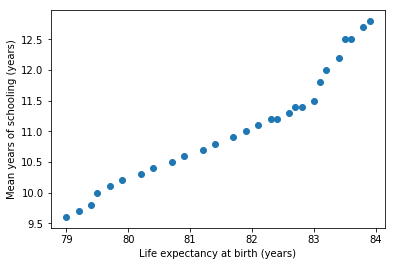

In [35]:
plot_health_by_country(inds_df, "Life expectancy at birth (years)", "Mean years of schooling (years)", "Japan")

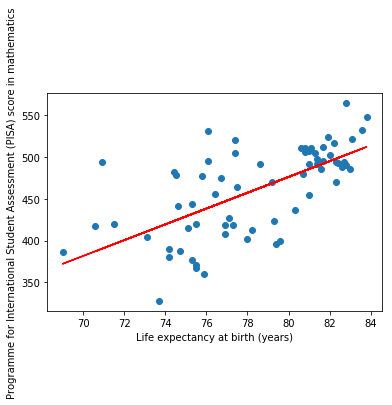

In [7]:
def plot_pisa(df, type_score):
    #Retrieves the rows where the indicator is equal to the respective values
    life_expectancy = df[df.indicator_name == "Life expectancy at birth (years)"]
    pisa = df[df.indicator_name == "Programme for International Student Assessment (PISA) score in {}".format(type_score)]
    life_val = []
    pisa_val = []
    for i in range(len(life_expectancy)):
        c_val = life_expectancy["country_name"].iloc[i]
        #checks to see if both life_expectancy and pisa have this country entry 
        if c_val in list(pisa["country_name"]):
            life_val.append(life_expectancy["2015"].iloc[i])
            #picks out the pisa entry for that country for 2015
            pisa_val.append(pisa[pisa.country_name == c_val]["2015"].iloc[0])
    plt.xlabel("Life expectancy at birth (years)")
    plt.ylabel("Programme for International Student Assessment (PISA) score in {}".format(type_score))
    plt.scatter(life_val, pisa_val)
    fit = np.polyfit(life_val, pisa_val, 1)
    fit_fn = np.poly1d(fit)
    plt.plot(life_val, fit_fn(life_val), color="red")

plot_pisa(inds_df, "mathematics")

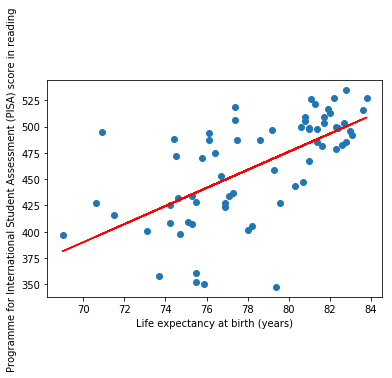

In [8]:
plot_pisa(inds_df, "reading")

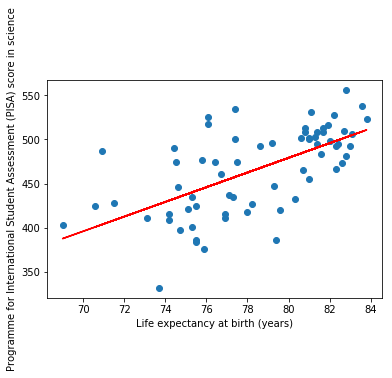

In [9]:
plot_pisa(inds_df, "science")